In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import simulation_process
from keras.models import load_model
from importlib import reload
from PGAgent import PGAgent
import timeit

Using TensorFlow backend.


# 0. Load Data

In [2]:
data=pd.read_csv("long_term_maximum_CPU_usage.csv")
data_mem=pd.read_csv("long_term_maximum_mem_usage.csv")

In [3]:
data2=data_mem.fillna(0)
data2=np.array(data2)
data2=data2[:1000,:]
data1=data.fillna(0)
data1=np.array(data1)
data1=data1[:1000,:]
data1

array([[0.3555  , 0.3252  , 0.07507 , ..., 0.09277 , 0.02365 , 0.      ],
       [0.2617  , 0.3594  , 0.06982 , ..., 0.04437 , 0.003883, 0.01797 ],
       [0.3643  , 0.375   , 0.1321  , ..., 0.03149 , 0.      , 0.      ],
       ...,
       [0.4136  , 0.3296  , 0.      , ..., 0.006264, 0.      , 0.08936 ],
       [0.3589  , 0.3789  , 0.      , ..., 0.01743 , 0.      , 0.09485 ],
       [0.4141  , 0.2383  , 0.      , ..., 0.003605, 0.      , 0.03674 ]])

In [4]:
row_num=data1.shape[0]
col_num=data1.shape[1]

# 1. LSTM Prediction Model

In [5]:
lag=8;
model=load_model('lstm_model2.h5')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
_________________________________________________________________
activation_10 (Activation)   (None, 1)                 0         
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


# 2. Load Reinforcement Learning Model

In [6]:
PM_num=1000;
state_size=PM_num
action_size=(PM_num-1)*3+1
agent=PGAgent(state_size,action_size)
agent.model=load_model("RL_1000.h5")

C:\Users\Jimmy\Desktop\Project\Prediction_Work1\src\PGAgent.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, input_shape=(1000,), activation="relu", kernel_initializer="he_uniform")`
  model.add(Dense(100, input_shape=(self.state_size,),activation='relu', init='he_uniform'))
C:\Users\Jimmy\Desktop\Project\Prediction_Work1\src\PGAgent.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="he_uniform")`
  model.add(Dense(100, activation='relu', init='he_uniform'))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 2998)              302798    
Total params: 412,998
Trainable params: 412,998
Non-trainable params: 0
_________________________________________________________________


# 3. Setup Initial Simulation Environment

In [12]:
# Environment Settings
PM_num=1000;
VM_num=2000;
# PM Trace Generation
PM_data=np.zeros([row_num,PM_num])
PM_vm_list=[]
PM_vm_list1=PM_vm_list.copy()
PM_vm_list2=PM_vm_list.copy()
PM_vm_list3=PM_vm_list.copy()
PM_vm_list4=PM_vm_list.copy()
for i in range (PM_num):
    chosen_vm_num=np.random.randint(4)
    chosen_column=list(np.random.randint(col_num,size=chosen_vm_num))
    PM_vm_list.append(chosen_column)    
    PM_vm_list1.append(chosen_column.copy())
    PM_vm_list2.append(chosen_column.copy())
    PM_vm_list3.append(chosen_column.copy())
    PM_vm_list4.append(chosen_column.copy())

    for j in range( chosen_vm_num):
        PM_data[:,i]+=data1[:,chosen_column[j]]

# 4. Define VM Migration Policy( Domain Knowledge & RL)

In [8]:
def VM_migration_policy(PM_num,PM_next_workload, PM_next_workload_data,PM_vm_list):
    migration_num=0
    migration_list=[]
    for mm in range(PM_num):
        if PM_next_workload[mm]>0.8:
            migration_list.append(mm)
    for index in migration_list:
        margin=PM_next_workload[index]-0.5
        PM_migration_index=index
        migration_task_index,migration_task_load=simulation_process.find_task_migration(PM_migration_index,margin,PM_next_workload_data) 
        PM_Acception_load=min(PM_next_workload)+migration_task_load 
        if PM_Acception_load<0.7: 
            PM_acception_index=PM_next_workload.index(min(PM_next_workload))
            simulation_process.migration_process(PM_migration_index,migration_task_index,PM_acception_index,PM_vm_list,PM_next_workload_data,PM_next_workload)
            migration_num+=1
    return migration_num

In [9]:
def RL_train_epoch_exe(PM_num,state,PM_current_workload_data,PM_current_workload,PM_vm_list,PM_vm_list_status,train_status):
    agent.states, agent.probs, agent.gradients, agent.rewards = [], [], [], []
    mig_num=0
    overhead_time=0
    for i in range(PM_num):
        start=timeit.default_timer()
        NN_state=simulation_process.get_nn_state(state,i)
        time_spend=timeit.default_timer()-start
        if NN_state[0]==3:
            action,prob=agent.act(NN_state)
            state,reward,SLo=simulation_process.env_step(i,PM_current_workload_data,PM_current_workload,PM_vm_list,action,PM_vm_list_status)
            time_spend=timeit.default_timer()-start
            agent.remember(NN_state,action,prob,reward)
            mig_num+=1
        overhead_time=max(overhead_time,time_spend)
   # print(agent.rewards)
    #print(agent.states)
    if(len(agent.rewards)>0 and train_status==1):
        agent.train()
    agent.states, agent.probs, agent.gradients, agent.rewards = [], [], [], []
    SLo=len(list(filter(lambda x: x>0.95 , PM_current_workload)))
    return SLo,state,mig_num,overhead_time

# 5. Simluation Process

In [13]:
migration_num=0   # prediction migration using domain knowledge
migration_num1=0  # Active migration using domain knowledge
migration_num3=0  # Active Reinforcement Learning
migration_num4=0  # Prediction Reinforcement Learning
nonmigr_num=0

SLo_migration=0
SLo_migration1=0
SLo_migration3=0
SLo_migration4=0
SLo_nonmigr=0

time_spend_migration=0
time_spend_migration1=0
time_spend_migration3=0
time_spend_migration4=0
time_spend_nonmigr=0

for current_time in range(500):
    initial_time=10

    PM_current_workload_data, PM_current_workload=simulation_process.PM_current_workload(data1,PM_vm_list,initial_time+current_time,PM_num)
    PM_current_workload_data1, PM_current_workload1=simulation_process.PM_current_workload(data1,PM_vm_list1,initial_time+current_time,PM_num)
    PM_current_workload_data2, PM_current_workload2=simulation_process.PM_current_workload(data1,PM_vm_list2,initial_time+current_time,PM_num)
    PM_current_workload_data3, PM_current_workload3=simulation_process.PM_current_workload(data1,PM_vm_list3,initial_time+current_time,PM_num)
    PM_current_workload_data4, PM_current_workload4=simulation_process.PM_current_workload(data1,PM_vm_list4,initial_time+current_time,PM_num)
 
    SLo_migration+=len(list(filter(lambda x: x>0.95 , PM_current_workload)))
    SLo_migration1+=len(list(filter(lambda x: x>0.95, PM_current_workload1)))
    SLo_migration3+=len(list(filter(lambda x: x>0.95, PM_current_workload3)))
    SLo_migration4+=len(list(filter(lambda x: x>0.95, PM_current_workload4)))
    SLo_nonmigr+=len(list(filter(lambda x: x>0.95, PM_current_workload2)))

    ############prediction migration using domain knowledge#############
    start=timeit.default_timer()
    PM_next_workload_data, PM_next_workload= simulation_process.PM_workload_prediction(model,lag,data1,PM_vm_list,initial_time+current_time,PM_num)
    time_spend_migration+=(timeit.default_timer()-start)/1000
    start=timeit.default_timer()
    mig_num=VM_migration_policy(PM_num,PM_next_workload, PM_next_workload_data,PM_vm_list)
    migration_num+=mig_num
    time_spend_migration+=timeit.default_timer()-start
    
    ################Active migration using domain knowledge#############
    start=timeit.default_timer()
    mig_num1=VM_migration_policy(PM_num,PM_current_workload1, PM_current_workload_data1,PM_vm_list1)
    migration_num1+=mig_num1
    time_spend_migration1+=timeit.default_timer()-start
    
    ################Active Reinforcement Learning#################
    start=timeit.default_timer()
    state=simulation_process.observation_state(PM_current_workload3,1)
    SLo,state,mig_num3,time_spend=RL_train_epoch_exe(PM_num,state,PM_current_workload_data3,PM_current_workload3,PM_vm_list3,1,0)
    migration_num3+=mig_num3
    time_spend_migration3+=time_spend
    ################Prediction Reinforcement Learning################
    start=timeit.default_timer()
    PM_next_workload_data4, PM_next_workload4= simulation_process.PM_workload_prediction(model,lag,data1,PM_vm_list4,initial_time+current_time,PM_num)     
    time_spend_migration4+=(timeit.default_timer()-start)/1000
    start=timeit.default_timer()
    state4=simulation_process.observation_state(PM_next_workload4,1)
    SLo4,state4,mig_num4,time_spend=RL_train_epoch_exe(PM_num,state4,PM_next_workload_data4,PM_next_workload4,PM_vm_list4,1,0)
    migration_num4+=mig_num4
    time_spend_migration4+=time_spend


    print(current_time,SLo_migration,SLo_nonmigr,SLo_migration1,SLo_migration3,SLo_migration4)
    print(current_time,time_spend_migration,time_spend_migration1,time_spend_migration3,time_spend_migration4)

0 4 4 4 4 4
0 0.002528722900048933 0.0032982000000174594 0.0030430999999566666 0.004332599699972775
1 4 5 4 4 4
1 0.004884135000033836 0.0034160000000156288 0.006015499999989515 0.007209061699931624
2 4 6 4 4 4
2 0.006614327000015862 0.0043579999999678876 0.0067861999999649925 0.009377533099959295
3 4 7 4 4 4
3 0.009004566900017665 0.004550699999981589 0.007396399999947789 0.011819370799947706
4 4 8 4 4 4
4 0.010798560500012287 0.0050658000000112224 0.008116899999947691 0.014078380199923914
5 5 10 5 5 5
5 0.01253487170003092 0.005363799999997809 0.011031899999920824 0.01682356859991944
6 5 10 5 5 5
6 0.014392942400062225 0.0061342000000195185 0.01168179999996255 0.019195093799899667
7 5 11 5 5 5
7 0.016156463200081135 0.006268000000034135 0.012179099999968912 0.02165733189992642
8 5 11 5 5 5
8 0.018283627300105763 0.006672600000001694 0.01488560000001371 0.024082405599933566
9 5 13 5 6 6
9 0.020097975800111554 0.007613600000013321 0.017659400000013648 0.02641733269991636
10 5 14 5 7 7


82 39 113 35 41 50
82 0.1626384007003851 0.03209350000003042 0.12519710000026407 0.2263939774002986
83 39 113 35 41 50
83 0.1643400490003636 0.03265219999997271 0.1276247000002968 0.2294340042002931
84 40 114 35 41 51
84 0.16609673490036428 0.032792799999981526 0.12821370000028764 0.23372438530024592
85 41 116 35 42 53
85 0.1680596862002847 0.032966299999941384 0.13099370000020372 0.2380195549003114
86 41 118 35 42 53
86 0.16977028080024495 0.03309539999992239 0.13211550000016814 0.2402041211003599
87 42 119 35 43 54
87 0.17148996140023717 0.03322309999992967 0.13466980000021067 0.2424069638004428
88 42 119 35 43 54
88 0.1731829376002667 0.03333869999988792 0.13517070000023068 0.24688896550049597
89 42 120 35 43 54
89 0.17510468110021424 0.03347369999988814 0.1357495000002018 0.2509145475004473
90 43 123 36 44 55
90 0.1769083833002266 0.03384469999986095 0.13831700000025648 0.2549642387005514
91 43 125 36 44 56
91 0.17861452060024505 0.034079899999881036 0.13891220000027715 0.257221854

163 85 221 72 87 96
163 0.31440722840028557 0.05533730000018977 0.23279110000112269 0.4445476436001351
164 85 222 72 87 96
164 0.31615304710024483 0.05545350000028293 0.23334520000116754 0.44666955479997833
165 85 223 72 87 96
165 0.3181975161003396 0.055573200000424094 0.2340937000010399 0.44882785779995144
166 87 226 74 89 99
166 0.320819648000417 0.05588620000042965 0.23676320000117812 0.45157967170007773
167 90 229 76 92 103
167 0.32254390770045926 0.0562016000005201 0.23958060000109072 0.45554128990001247
168 90 230 76 92 103
168 0.32442778290046853 0.05668690000055676 0.2402783000011368 0.45765959050020083
169 90 231 76 92 103
169 0.3261215872006268 0.05680600000044933 0.24277410000104283 0.459709176900184
170 90 232 76 92 103
170 0.3278704119004632 0.056935700000337874 0.24328740000123616 0.46212369150004806
171 90 233 76 92 103
171 0.32973113220041034 0.057065900000395686 0.2441305000011198 0.4645095525999433
172 90 234 76 92 103
172 0.3314555585002737 0.05719730000049594 0.244

254 116 338 99 119 132
254 0.49150510330001285 0.07681970000061256 0.336825200001158 0.6923828048987076
255 116 338 99 119 132
255 0.49338647340000047 0.07693240000065771 0.3377106000011736 0.6952679702987802
256 116 339 99 119 132
256 0.49559733670009554 0.07747230000080663 0.33882510000125876 0.7003151741988317
257 117 340 100 120 133
257 0.4975094283999771 0.0777208000008045 0.3415250000011838 0.7026962751988662
258 117 341 100 120 133
258 0.4994806411001133 0.07790280000079974 0.34233430000108456 0.7062602739989968
259 117 342 100 120 133
259 0.5011569890000811 0.07803960000086363 0.3433318000008967 0.7082962270989219
260 117 343 100 120 133
260 0.5028751781000546 0.07835930000072722 0.3438132000010228 0.7106937415988893
261 117 344 100 120 133
261 0.5046468612000391 0.07848690000076886 0.3450905000011062 0.7131391795989518
262 117 344 100 120 133
262 0.5067803930001754 0.07861950000068418 0.34577580000109265 0.7155249748989188
263 120 346 103 123 136
263 0.5085560038000271 0.07902

333 143 412 124 149 163
333 0.8450508300008521 0.0940533000006667 0.4632398000014746 0.9142642994986901
334 143 412 124 149 163
334 0.847277963000752 0.09418370000065579 0.4638615000012578 0.9192751435987732
335 145 415 126 151 165
335 0.849759524500739 0.09449830000056636 0.46643690000132665 0.923745305698702
336 149 419 130 155 169
336 0.8515529195006009 0.09500070000075311 0.46923760000140646 0.9266678017986613
337 149 420 130 155 169
337 0.8543107547006334 0.09513250000071594 0.47001660000137235 0.9294151761987333
338 149 421 130 155 169
338 0.8560895260008231 0.09525440000078333 0.47163250000130574 0.9323601008986195
339 149 421 130 155 169
339 0.8584232608010188 0.09538900000092099 0.4724792000013167 0.9348050202986058
340 149 422 130 155 169
340 0.8602230643010146 0.09571350000072698 0.47379410000121425 0.9375427190986779
341 149 423 130 155 171
341 0.8620898675010115 0.09611500000067963 0.4763525000012123 0.9397770174987825
342 149 423 130 155 171
342 0.8642604605011691 0.09645

412 169 486 146 175 195
412 0.9976252160043961 0.11037400000003572 0.5630190000010771 1.1356551216979738
413 169 487 146 175 195
413 0.9993710534044014 0.11049709999969082 0.5641257000011137 1.1384871727982626
414 169 489 146 175 195
414 1.001857661204326 0.1106292999995162 0.5648812000013095 1.1436167534982087
415 172 491 149 178 198
415 1.00360635640447 0.11106349999971599 0.5674666000013531 1.1457773016982087
416 172 492 149 178 198
416 1.0053495180041605 0.11118399999958228 0.5679980000013529 1.1496875115981928
417 172 493 149 178 199
417 1.0070756367042404 0.11131189999940716 0.568695400001161 1.1519102370982417
418 172 494 149 178 199
418 1.008766136804415 0.11144109999912644 0.5692495000012059 1.1541153665980604
419 172 495 149 178 199
419 1.010493819204566 0.11155289999913975 0.5701472000014292 1.156273742098172
420 172 497 149 178 199
420 1.012995811804656 0.11177189999915527 0.5728145000011864 1.1603312160981107
421 174 501 151 181 201
421 1.015189029304394 0.1121339999992301

491 195 593 172 203 235
491 1.1435499957032524 0.12720879999932322 0.6532554000032178 1.3404085353986483
492 195 594 172 203 235
492 1.145241061703395 0.1273343999993699 0.6541960000031395 1.3425864527984026
493 195 595 172 203 235
493 1.147027781603291 0.12752099999960365 0.6547539000030156 1.3451427523980597
494 195 596 172 203 235
494 1.1487482127029154 0.12764779999923803 0.6553122000027543 1.3471568723979244
495 195 597 172 203 235
495 1.150812266302823 0.1277728999995702 0.6558716000026834 1.351509601297945
496 197 600 174 205 237
496 1.1526556572026794 0.128430399999786 0.658704700002545 1.35439897949791
497 197 602 174 205 238
497 1.1545725676026959 0.12855529999995952 0.6596433000026991 1.3574803986977644
498 197 603 174 205 238
498 1.1565390802026696 0.12868499999984806 0.660195100002511 1.3603301788976863
499 197 604 174 205 238
499 1.1586571191029797 0.1289816999998834 0.6628754000025765 1.3625760789978825


# 6. Metric Evalution

# (1). SLO Violation Rate

In [25]:
prediction_PM_SLO=SLo_migration1/(500*PM_num)
No_mig_PM_SLO=SLo_nonmigr/(500*PM_num)
Act_PM_SLO1=SLo_migration/(500*PM_num)
RL_PM_SLO=SLo_migration4/(500*PM_num)
pred_RL_PM_SLO=SLo_migration3/(500*PM_num)


In [26]:
SLA_Rate=[prediction_PM_SLO,Act_PM_SLO1,pred_RL_PM_SLO,RL_PM_SLO,No_mig_PM_SLO]

In [27]:
SLA_Rate

[0.000348, 0.000394, 0.00041, 0.000476, 0.001208]

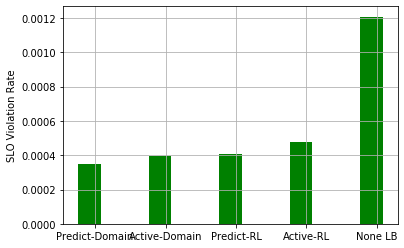

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
 
def draw_bar(labels,quants,name):
    width = 0.4
    ind = np.linspace(0,5,5)
    # make a square figure
    fig = plt.figure(1)
    ax  = fig.add_subplot(111)
    # Bar Plot
    ax.bar(ind-width/4,quants,width,color='green')
    # Set the ticks on x-axis
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    # labels
    #ax.set_xlabel()
    ax.set_ylabel(name)
    # title
    #ax.set_title('Top 10 GDP Countries', bbox={'facecolor':'0.8', 'pad':5})
    plt.grid(True)
    plt.show()
    plt.savefig("SLA_Rate.jpg")
    plt.close()
 
labels   = ['Predict-Domain', 'Active-Domain','Predict-RL','Active-RL','None LB']
 
quants   = SLA_Rate
 
draw_bar(labels,quants,"SLO Violation Rate")


# (2). Migration Num

In [29]:
migration_num_list=[migration_num,migration_num1,migration_num4,migration_num3,0]

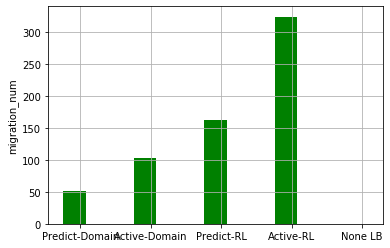

In [30]:
draw_bar(labels,migration_num_list,"migration_num")

# (3).  Overhead 

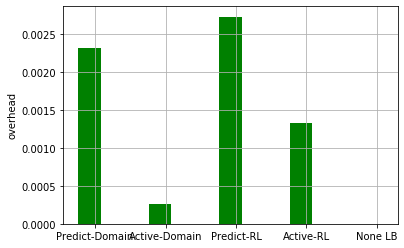

In [31]:
overhead_list=[time_spend_migration,time_spend_migration1,time_spend_migration4,time_spend_migration3,0]
overhead_list=np.array(overhead_list)/500
draw_bar(labels,overhead_list,"overhead")
